<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loss-Minimization-Using-a-Program" data-toc-modified-id="Loss-Minimization-Using-a-Program-1">Loss Minimization Using a Program</a></span></li><li><span><a href="#Issues-with-simple_minimize" data-toc-modified-id="Issues-with-simple_minimize-2">Issues with <code>simple_minimize</code></a></span></li></ul></div>

In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

In [2]:
# HIDDEN
def mse(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

def points_and_loss(y_vals, xlim, loss_fn):
    thetas = np.arange(xlim[0], xlim[1] + 0.01, 0.05)
    losses = [loss_fn(theta, y_vals) for theta in thetas]
    
    plt.figure(figsize=(9, 2))
    
    ax = plt.subplot(121)
    sns.rugplot(y_vals, height=0.3, ax=ax)
    plt.xlim(*xlim)
    plt.title('Points')
    plt.xlabel('Tip Percent')
    
    ax = plt.subplot(122)
    plt.plot(thetas, losses)
    plt.xlim(*xlim)
    plt.title(loss_fn.__name__)
    plt.xlabel(r'$ \theta $')
    plt.ylabel('Loss')
    plt.legend()

## Loss Minimization Using a Program

Let us return to our constant model:

$$
\theta = C
$$

We will use the mean squared error loss function:

$$
\begin{aligned}
L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \theta)^2\\
\end{aligned}
$$

For simplicity, we will use the dataset $ \textbf{y} = [ 12, 13, 15, 16, 17 ] $. We know from our analytical approach in a previous chapter that the minimizing $ \theta $ for the MSE is $ \text{mean}(y) = 14.6 $. Let's see whether we can find the same value by writing a program.

If we write the program well, we will be able to use the same program on any loss function in order to find the minimizing value of $ \theta $, including the mathematically complicated Huber loss:

$$
L_\alpha(\theta, \textbf{y}) = \frac{1}{n} \sum_{i=1}^n \begin{cases}
    \frac{1}{2}(y_i - \theta)^2 &  | y_i - \theta | \le \alpha \\
    \alpha ( |y_i - \theta| - \frac{1}{2}\alpha ) & \text{otherwise}
\end{cases}
$$

First, we create a rug plot of the data points. To the right of the rug plot we plot the MSE for different values of $ \theta $.

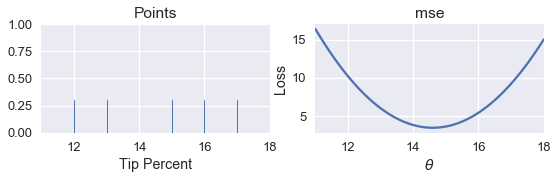

In [3]:
# HIDDEN
pts = np.array([12, 13, 15, 16, 17])
points_and_loss(pts, (11, 18), mse)

How might we write a program to automatically find the minimizing value of $ \theta $? The simplest method is to compute the loss for many values $ \theta $. Then, we can return the $ \theta $ value that resulted in the least loss.

We define a function called `simple_minimize` that takes in a loss function, an array of data points, and an array of $\theta$ values to try.

In [4]:
def simple_minimize(loss_fn, dataset, thetas):
    '''
    Returns the value of theta in thetas that produces the least loss
    on a given dataset.
    '''
    losses = [loss_fn(theta, dataset) for theta in thetas]
    return thetas[np.argmin(losses)]

Then, we can define a function to compute the MSE and pass it into `simple_minimize`.

In [5]:
def mse(theta, dataset):
    return np.mean((dataset - theta) ** 2)

dataset = np.array([12, 13, 15, 16, 17])
thetas = np.arange(12, 18, 0.1)

simple_minimize(mse, dataset, thetas)

14.599999999999991

This is close to the expected value:

In [6]:
# Compute the minimizing theta using the analytical formula
np.mean(dataset)

14.6

Now, we can define a function to compute the Huber loss and plot the loss against $\theta $.

In [7]:
def huber_loss(theta, dataset, alpha = 1):
    d = np.abs(theta - dataset)
    return np.mean(
        np.where(d < alpha,
                 (theta - dataset)**2 / 2.0,
                 alpha * (d - alpha / 2.0))
    )

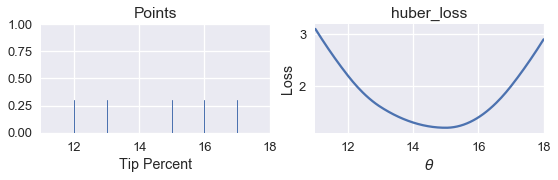

In [8]:
# HIDDEN
points_and_loss(pts, (11, 18), huber_loss)

Although we can see that the minimizing value of $ \theta $ should be close to 15, we do not have an analytical method of finding $ \theta $ directly for the Huber loss. Instead, we can use our `simple_minimize` function.

In [9]:
simple_minimize(huber_loss, dataset, thetas)

14.999999999999989

Now, we can return to our original dataset of tip percentages and find the best value for $ \theta $ using the Huber loss.

In [10]:
tips = sns.load_dataset('tips')
tips['pcttip'] = tips['tip'] / tips['total_bill'] * 100
tips.head()

,total_bill,tip,sex,smoker,day,time,size,pcttip
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765


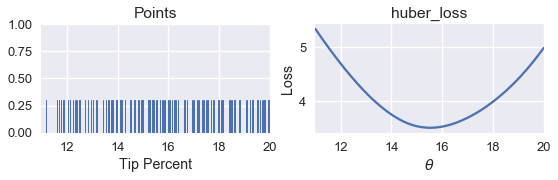

In [11]:
# HIDDEN
points_and_loss(tips['pcttip'], (11, 20), huber_loss)

In [12]:
simple_minimize(huber_loss, tips['pcttip'], thetas)

15.499999999999988

We can see that using the Huber loss gives us $ \hat{\theta} = 15.5 $. We can now compare the minimizing $\hat{\theta} $ values for MSE, MAE, and Huber loss.

In [13]:
print(f"               MSE: theta_hat = {tips['pcttip'].mean():.2f}")
print(f"               MAE: theta_hat = {tips['pcttip'].median():.2f}")
print(f"        Huber loss: theta_hat = 15.50")

               MSE: theta_hat = 16.08
               MAE: theta_hat = 15.48
        Huber loss: theta_hat = 15.50


We can see that the Huber loss is closer to the MAE since it is less affected by the outliers on the right side of the tip percentage distribution:

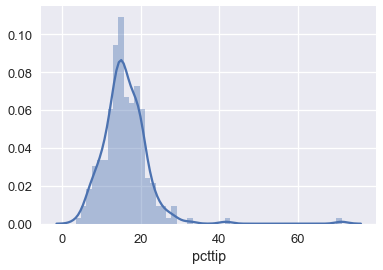

In [14]:
sns.distplot(tips['pcttip'], bins=50);

## Issues with `simple_minimize`

Although `simple_minimize` allows us to minimize loss functions, it has some flaws that make it unsuitable for general purpose use. Its primary issue is that it only works with predetermined values of $ \theta $ to test. For example, in this code snippet we used above, we had to manually define $ \theta $ values in between 12 and 18.

```python
dataset = np.array([12, 13, 15, 16, 17])
thetas = np.arange(12, 18, 0.1)

simple_minimize(mse, dataset, thetas)
```

How did we know to examine the range between 12 and 18? We had to inspect the plot of the loss function manually and see that there was a minima in that range. This process becomes impractical as we add extra complexity to our models. In addition, we manually specified a step size of 0.1 in the code above. However, if the optimal value of $ \theta $ were 12.043, our `simple_minimize` function would round to 12.00, the nearest multiple of 0.1. 

We can solve both of these issues at once by using a method called *gradient descent*.